In [1]:
import pandas as pd
import igraph as ig
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('../debate_dataset.csv')
df.head()

,comment_id,post_id,debate_group,comment_user_name,commented_user_name,comment_body,comment_score
0,kxtjk7w,1bulhj9,1,T_JaM_T,theenkos,"No, la quantità di acqua che cade sotto forma ...",17
1,kxub8sy,1bulhj9,1,T_JaM_T,CosmoTwoFins,L'avevo sentito due o tre mesi fa in una trasm...,1
2,kxww2q1,1bulhj9,1,_The_Prov_,lore_mila_,L'unica a inquinare meno pro capite rispetto a...,2
3,kxuegzt,1bulhj9,1,_The_Prov_,Reforged_Narsil,"Si, chiedo scusa, il mio dato si riferiva solo...",2
4,kxtgmx2,1bulhj9,2,davidevernizzi,Dangerous-Practice-6,"Senza sarcasmo o polemica, cosa? Per come la v...",4


In [3]:
post_id_dict = {}
dataframe_list = []
for post_id in df['post_id'].unique():
    dataframe = df[df['post_id'] == post_id]
    dataframe_list.append(dataframe)
    post_id_dict[post_id] = dataframe

In [4]:
def create_graph_from_dataframe(dataframe):
    graph = ig.Graph(directed=True)
    graph.add_vertex(name='root', label='root')
    for comment in dataframe.iterrows():
        if comment[1]['comment_user_name'] not in graph.vs['name']:
            graph.add_vertex(name=comment[1]['comment_user_name'], label=comment[1]['comment_user_name'])
        if comment[1]['commented_user_name'] not in graph.vs['name']:
            graph.add_vertex(name=comment[1]['commented_user_name'], label=comment[1]['commented_user_name'])
        graph.add_edge(comment[1]['comment_user_name'], comment[1]['commented_user_name'])
    
    graph.delete_vertices('root')
    return graph

post_id_graph = {}
for dataframe in dataframe_list:
    graph = create_graph_from_dataframe(dataframe)
    post_id_graph[dataframe['post_id'].iloc[0]] = graph

# Metriche di valutazione dei grafi di dibattitio

## Metriche sul POST

### Calcolo dell' average degree
Calcolando l'average degree di ciascun post, è possibile farsi un'idea generale di quanto gli utenti tendono ad interagire tra di loro 

In [5]:
def degree_distribution(graph):
    degree = graph.degree()
    n = graph.vcount()
    degree = np.array(degree)

    return 1/n * sum(degree)

### Distribuzione dei gradi
Questo grafico ci permette di osservare la distribuzione dei gradi di ogni nodo all'interno del grafo, offrendo una visione chiara del livello di interazione degli utenti. **Qual è la percentuale di utenti che hanno interagito poco/tanto con il post?**

In [6]:
def compute_degree_distribution(graph):
    degree = graph.degree()
    x = np.unique(degree)
    degree = np.array(degree)
    y = []
    for i in x:
        y.append(sum(degree == i)/ len(degree)) 
    return x, y

Post:1bulhj9 as average degree of 5.0625
Post:1b6cg4q as average degree of 4.777777777777778
Post:1d5h5h6 as average degree of 4.3896103896103895
Post:17z2hci as average degree of 5.663157894736842
Post:197vo6o as average degree of 3.0625
Post:19aeo2k as average degree of 3.393939393939394
Post:1cwqkqe as average degree of 5.029411764705882
Post:10v8sey as average degree of 4.927835051546392
Post:17lese9 as average degree of 5.069767441860465


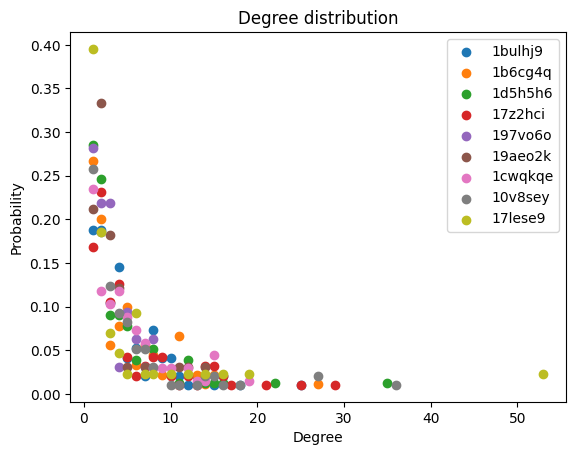

<Figure size 640x480 with 0 Axes>

In [12]:
for post_graph in post_id_graph:
    print(f'Post:{post_graph} as average degree of {degree_distribution(post_id_graph[post_graph])}')
    x, y = compute_degree_distribution(post_id_graph[post_graph])
    plt.scatter(x, y)
    plt.xlabel('Degree')
    plt.ylabel('Probability')
    plt.title('Degree distribution')

plt.legend(post_id_graph.keys())
plt.show()

## Metriche sul Dibattito

### Coefficiente di clustering medio
Tramite il coefficiente di clustring medio possiamo ottenere una misura golbale del grado di coesione degli utenti all'interno della dibattito, ovvero quanto gli utenti hanno interagito tra di loro all'interno della discussione in questione.

In [8]:
def compute_average_clustering_coefficient(graph):
    clustering_medio = graph.transitivity_avglocal_undirected()
    if clustering_medio != clustering_medio:
        clustering_medio = 0.0
    
    return clustering_medio

In [9]:
for post_df in post_id_dict.values():
    post_id = post_df['post_id'].iloc[0]
    for debate_id in post_df['debate_group'].unique():
        if debate_id != '0':
            debate_df = post_df[post_df['debate_group'] == debate_id]
            graph = create_graph_from_dataframe(debate_df)

In [10]:
def compute_debate_relevance(debate, graph):
    n_graph_nodes = graph.vcount()
    n_graph_edges = graph.ecount()
    n_nodes = debate.vcount()/n_graph_nodes
    n_edges = debate.ecount()/n_graph_edges
    avg_degree = degree_distribution(debate)
    clustering_coefficient = compute_average_clustering_coefficient(debate)
    return n_nodes + n_edges + avg_degree + clustering_coefficient
i = 1
for post_df in post_id_dict.values():
    post_id = post_df['post_id'].iloc[0]
    for debate_id in post_df['debate_group'].unique():
        if debate_id != '0':
            debate_df = post_df[post_df['debate_group'] == debate_id]
            debate_graph = create_graph_from_dataframe(debate_df)
            relevance = compute_debate_relevance(debate_graph, graph)
            print(f'{i}_Post:{post_id} Debate:{debate_id}  Relevance:{relevance}')
            i+=1

1_Post:1bulhj9 Debate:1  Relevance:142.45813311688312
2_Post:1bulhj9 Debate:2  Relevance:11.833333333333332
3_Post:1bulhj9 Debate:3  Relevance:16.2
4_Post:1bulhj9 Debate:4  Relevance:8.5
5_Post:1bulhj9 Debate:5  Relevance:8.5
6_Post:1bulhj9 Debate:6  Relevance:4.0
7_Post:1bulhj9 Debate:7  Relevance:5.5
8_Post:1bulhj9 Debate:8  Relevance:7.0
9_Post:1b6cg4q Debate:9  Relevance:126.0712037037037
10_Post:1b6cg4q Debate:10  Relevance:15.045454545454545
11_Post:1b6cg4q Debate:11  Relevance:16.0
12_Post:1b6cg4q Debate:12  Relevance:17.5
13_Post:1b6cg4q Debate:13  Relevance:8.5
14_Post:1b6cg4q Debate:14  Relevance:5.5
15_Post:1d5h5h6 Debate:15  Relevance:5.0
16_Post:1d5h5h6 Debate:16  Relevance:17.6
17_Post:1d5h5h6 Debate:17  Relevance:31.741964285714285
18_Post:1d5h5h6 Debate:18  Relevance:76.74932659932661
19_Post:1d5h5h6 Debate:19  Relevance:6.166666666666666
20_Post:1d5h5h6 Debate:20  Relevance:7.0
21_Post:17z2hci Debate:21  Relevance:182.99597794495756
22_Post:17z2hci Debate:22  Relevance